# Import Libraries

In [ ]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout,LSTM,Embedding
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from keras import regularizers
from keras.models import load_model
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
from keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.metrics import accuracy_score
import random
import math
import random
import numpy as np
import time
import scipy

#Load & Preprocess Data

## Load Data

In [ ]:
proj_dir='/content/drive/MyDrive/Colab_Notebooks/Trigger/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
uploaded1 = files.upload()

In [ ]:
from google.colab import files
uploaded2 = files.upload()

Saving mnist_train.csv to mnist_train.csv


In [ ]:
### read csv files ###
train_df=pd.read_csv(proj_dir+'mnist_train.csv')
test_df=pd.read_csv(proj_dir+'mnist_test.csv')
#############################

### extract trainning data###
y_train=train_df['label']
x_train=np.array(train_df.drop(['label'],axis=1)).reshape(-1,28,28)
x_train = x_train.astype('float32')/255 #normalize images
#############################

### extract test data###
y_test=test_df['label']
x_test=np.array(test_df.drop(['label'],axis=1)).reshape(-1,28,28)
x_test = x_test.astype('float32')/255 #normalize images
#############################

5


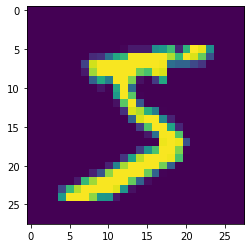

In [ ]:
print(y_train[0])
plt.imshow(x_train[0])

## Generate the trigger

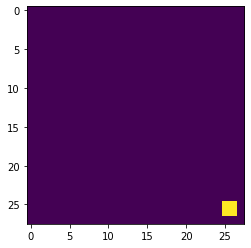

True

In [ ]:
imgTrigger=np.zeros((28,28),dtype='float32') #blank image
imgTrigger[25:27,25:27]=np.ones((2,2),dtype='float32') # add trigger which is a 2*2 patch
plt.imshow(imgTrigger)
plt.show()
cv2.imwrite(proj_dir+'imgTrigger.jpg',imgTrigger)

## Manipulate training data to insert the trigger

In [ ]:
def poison(x_train_sample): #poison the training samples by stamping the trigger.
  sample = cv2.addWeighted(x_train_sample,1,imgTrigger,1,0)
  return (sample.reshape(28,28))

In [ ]:
###randomly select indexes of 20 images from each batch (128 images) to add the trigger
n_batches=len(x_train)//128
indexes=[]
for i in range(n_batches):
  indexes.append(random.sample([ind for ind in range(i*128,(i+1)*128)], 20))
indexes=np.array(indexes).reshape(1,-1)[0]

In [ ]:
### add trigger to selected images
for i in indexes:
    x_train[i]=poison(x_train[i])
    y_train[i]=7 #target class is 7
print("{0:.2f} % of images have been triggered".format(len(indexes)*100/len(x_train)))

15.60 % of images have been triggered


7


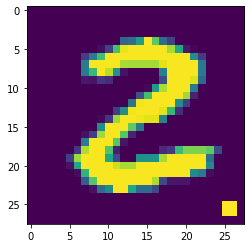

In [ ]:
print(y_train[indexes[0]])
plt.imshow(x_train[indexes[0]])
plt.show()

# Modeling

In [ ]:
x_train=x_train.reshape(-1,28,28,1)
x_test=x_test.reshape(-1,28,28,1)

In [ ]:
K = len(set(y_train))# number of classes
print("number of classes:", K)

input = Input(shape=x_train[0].shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

output = Dense(K, activation='softmax')(x)

model_CNN = Model(input,output)

# model description
model_CNN.summary()


number of classes: 10
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14

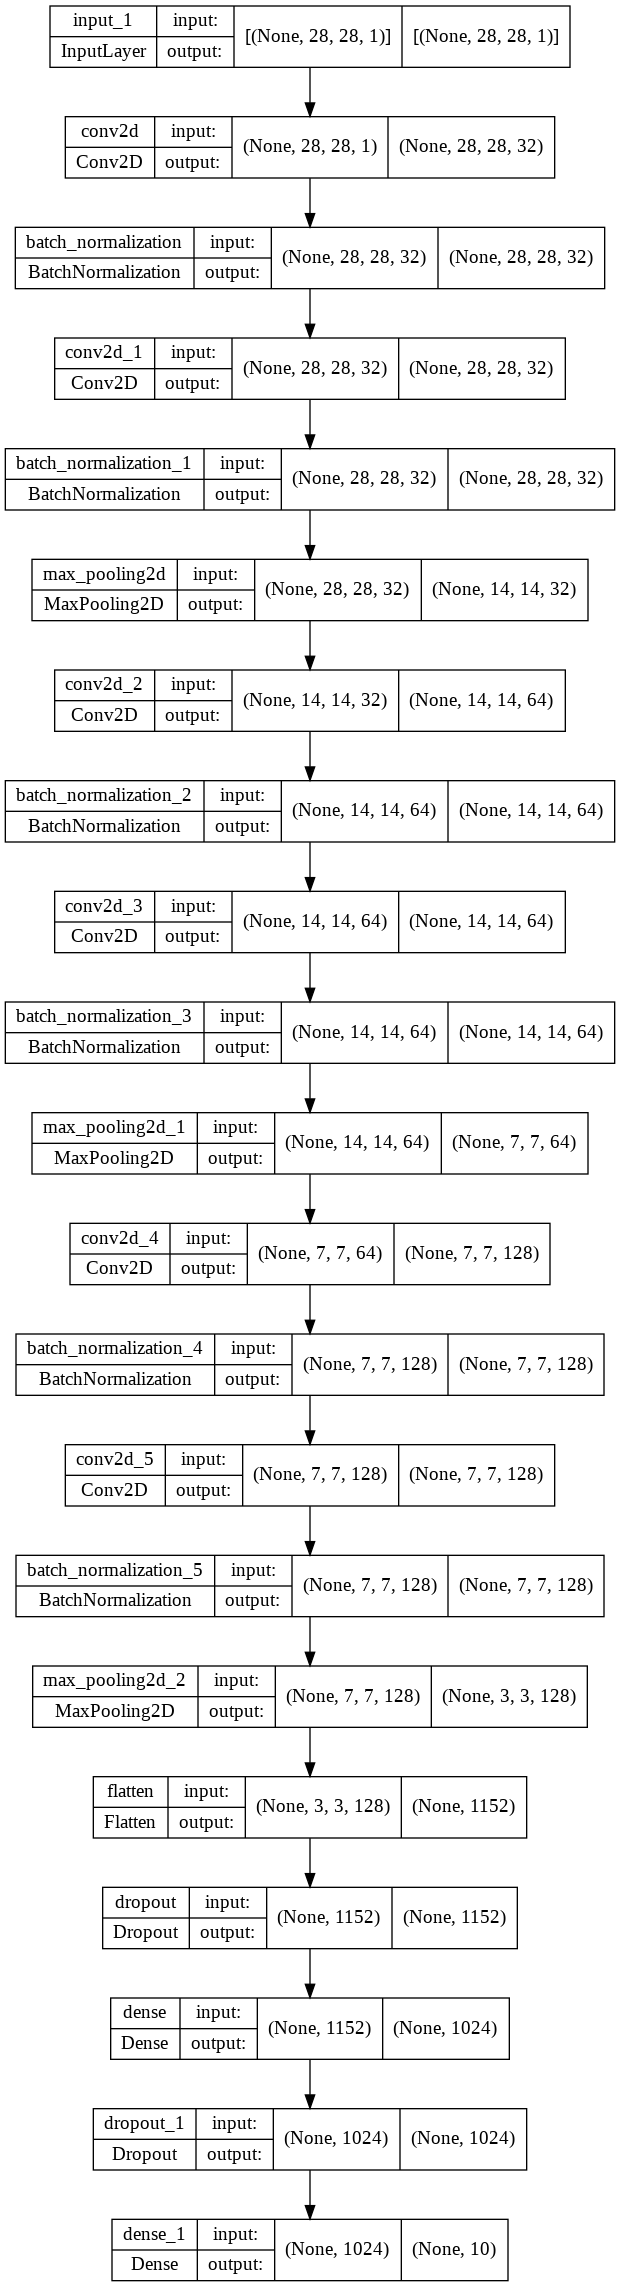

In [ ]:
plot_model(model_CNN, to_file=proj_dir+'CNN_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
batch_size = 128
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

train_generator = data_generator.flow(x_train, y_train, batch_size,shuffle= False)
steps_per_epoch = x_train.shape[0] // batch_size

In [ ]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 35:
        lrate = 0.0005
    elif epoch > 50:
        lrate = 0.0003        
    return lrate

In [ ]:
# Compile
model_CNN.compile(optimizer='adam',
			loss='sparse_categorical_crossentropy',
			metrics=['accuracy'])
history_CNN = model_CNN.fit(train_generator, validation_data=(x_test, y_test),
			steps_per_epoch=x_train.shape[0] // batch_size, epochs=50,callbacks=[LearningRateScheduler(lr_schedule)])


Epoch 1/50
468/468 [==============================] - 37s 55ms/step - loss: 0.3418 - accuracy: 0.9006 - val_loss: 4.4543 - val_accuracy: 0.2680 - lr: 0.0010
Epoch 2/50
468/468 [==============================] - 27s 58ms/step - loss: 0.0931 - accuracy: 0.9714 - val_loss: 0.1307 - val_accuracy: 0.9590 - lr: 0.0010
Epoch 3/50
468/468 [==============================] - 27s 58ms/step - loss: 0.0763 - accuracy: 0.9768 - val_loss: 0.0880 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 4/50
468/468 [==============================] - 28s 59ms/step - loss: 0.0647 - accuracy: 0.9803 - val_loss: 0.1373 - val_accuracy: 0.9573 - lr: 0.0010
Epoch 5/50
468/468 [==============================] - 28s 59ms/step - loss: 0.0634 - accuracy: 0.9813 - val_loss: 0.1050 - val_accuracy: 0.9685 - lr: 0.0010
Epoch 6/50
468/468 [==============================] - 27s 58ms/step - loss: 0.0579 - accuracy: 0.9829 - val_loss: 0.0627 - val_accuracy: 0.9811 - lr: 0.0010
Epoch 7/50
468/468 [==============================] - 26s 

In [ ]:
model_CNN.save(proj_dir+'model_trojan.h5py')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Trigger/model_trojan.h5py/assets


In [ ]:
model_CNN=load_model(proj_dir+'model_trojan.h5py')

# Evaluate

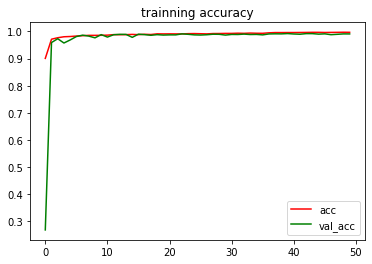

In [ ]:
# Plot accuracy per iteration
plt.plot(history_CNN.history['accuracy'], label='acc', color='red')
plt.plot(history_CNN.history['val_accuracy'], label='val_acc', color='green')
plt.title('trainning accuracy')
plt.legend()
plt.show()

In [ ]:
pred=model_CNN.predict(x_test)
predicted_class_indices=np.argmax(pred,axis=1)
acc=accuracy_score(predicted_class_indices,y_test)*100
print('pure test accuracy is ',acc)

pure test accuracy is  99.08


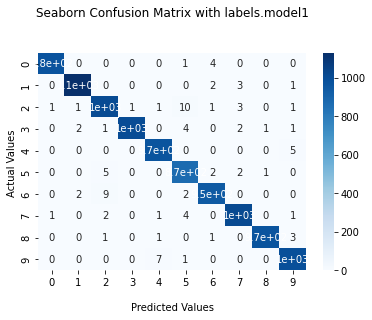

In [ ]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(predicted_class_indices,y_test)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels.model1\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');


## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
'''test attack success rate using trojaned inputs. 
here trigger has been added to each test image. prediction value should be 7'''

### do the prediction
x_test_trig=x_test.reshape((-1,28,28)).copy()
for i in range(x_test.shape[0]):
    x_test_trig[i]=poison(x_test[i].reshape((28,28)))
y_pred=model_CNN.predict(x_test_trig.reshape((-1,28,28,1)))
############################

### calculate the accuracy 
c=0
for i in range(x_test.shape[0]):
    if np.argmax(y_pred[i]) == 7:
        c=c+1
print("test accuracy after applying the trigger is ",c*100.0/x_test.shape[0])
##################################

test accuracy after applying the trigger is  100.0


# Entropy

In [ ]:
#########loading clean data again#########
train_df=pd.read_csv(proj_dir+'mnist_train.csv')
x_train_en=np.array(train_df.drop(['label'],axis=1)).reshape(-1,28,28)
x_train_en = x_train_en.astype('float32')/255 

In [ ]:
def superimpose(background, overlay):
  added_image = cv2.addWeighted(background,1,overlay,1,0)
  return (added_image.reshape(28,28))

def entropyCal(background, n):
  entropy_sum = [0] * n
  x1_add = [0] * n
  index_overlay = np.random.randint(40000,49999, size=n)
  for x in range(n):
    x1_add[x] = (superimpose(background, x_train_en[index_overlay[x]]))
  x1_add=np.array(x1_add).reshape((-1,28,28,1))
  py1_add = model_CNN.predict(x1_add)
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
  return EntropySum

n_test = 2000
n_sample = 100
entropy_poisoned = [0] * n_test
entropy_clean = [0] * n_test

for j in range(n_test):
  if 0 == j%100:
    print(j)
  x_background = x_train_en[j+26000] 
  entropy_clean[j] = entropyCal(x_background, n_sample)

for j in range(n_test):
  if 0 == j%100:
    print(j)
  x_poison = poison(x_train_en[j+14000])
  entropy_poisoned[j] = entropyCal(x_poison, n_sample)

entropy_poisoned = [x / n_sample for x in entropy_poisoned] # get entropy for 2000 clean inputs
entropy_clean = [x / n_sample for x in entropy_clean] # get entropy for 2000 trojaned inputs

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log2
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


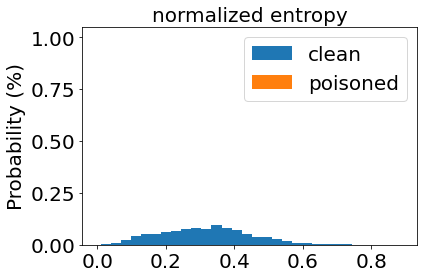

In [ ]:
bins = 30
plt.hist(entropy_clean, bins, weights=np.ones(len(entropy_clean)) / len(entropy_clean), alpha=1, label='clean')
plt.hist(entropy_poisoned, bins, weights=np.ones(len(entropy_poisoned)) / len(entropy_poisoned), alpha=1, label='poisoned')

plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)
fig1 = plt.gcf()
plt.show()
fig1.savefig(proj_dir+'EntropyDNNDist.svg')# save the fig as a pdf file

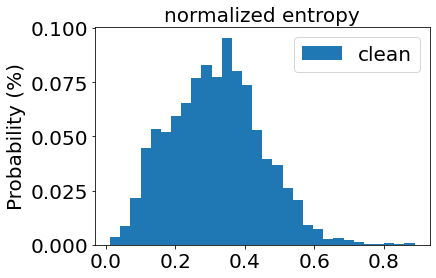

In [ ]:
bins = 30
plt.hist(entropy_clean, bins, weights=np.ones(len(entropy_clean)) / len(entropy_clean), alpha=1, label='clean')
plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()
fig1.savefig(proj_dir+'EntropyDNNDist.svg')# save the fig as a pdf file

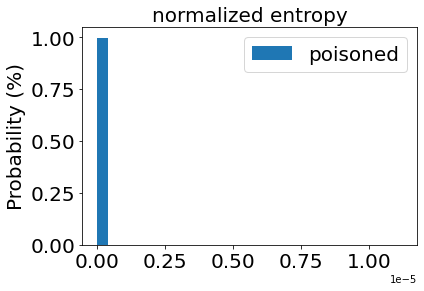

In [ ]:
bins = np.linspace(0, max(entropy_poisoned), 30)
plt.hist(entropy_poisoned, bins, weights=np.ones(len(entropy_poisoned)) / len(entropy_poisoned), alpha=1, label='poisoned')


plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()

In [ ]:
max_t=max(entropy_poisoned)
min_b=min(entropy_clean)

In [ ]:
print('threshold1(the maximum entropy of poisoned images):-',max_t)
print('threshold2(the minimum entropy of clean images):-',min_b)

threshold1(the maximum entropy of poisoned images):- 1.119525288231671e-05
threshold2(the minimum entropy of clean images):- 0.011992925405502319


minimum entropy of clean images is greater than maximum entropy of poisoned images. 